In [9]:
!pip install SQLAlchemy pymysql

## Conexión a mysql

In [10]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

HOST="localhost"; PORT=3306; USER="root"; PASSWORD="QUAKE10.350"
DB_DW="dw_multas"

engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_DW}")

def df_sql(sql, params=None):
    with engine.connect() as conn:
        return pd.read_sql(sql, conn, params=params)


## Roll-up: Total de ingresos por mes

,anio,mes,ingresos_mes
0,2021,1,20285.0
1,2021,2,48185.0
2,2021,3,30760.0
3,2021,4,24470.0
4,2021,5,33240.0
5,2021,6,30075.0
6,2021,7,22050.0
7,2021,8,30945.0
8,2021,9,23160.0
9,2021,10,23360.0


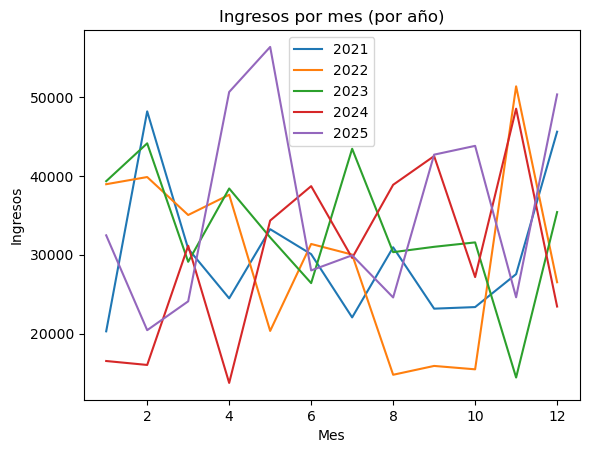

In [11]:
sql_mes = """
SELECT
  dt.anio,
  dt.mes,
  SUM(fm.importe) AS ingresos_mes
FROM FactMulta fm
JOIN DimTiempo dt ON dt.time_key = fm.time_key
GROUP BY dt.anio, dt.mes
ORDER BY dt.anio, dt.mes;
"""
df_mes = df_sql(sql_mes)
display(df_mes.head(12))


plt.figure()
for anio, sub in df_mes.groupby('anio'):
    sub_sorted = sub.sort_values('mes')
    plt.plot(sub_sorted['mes'], sub_sorted['ingresos_mes'], label=str(anio))
plt.title('Ingresos por mes (por año)')
plt.xlabel('Mes')
plt.ylabel('Ingresos')
plt.legend()
plt.show()

## Roll-up: Total de ingresos por año

,anio,ingresos_anio
0,2021,359675.0
1,2022,357180.0
2,2023,395735.0
3,2024,360555.0
4,2025,427945.0


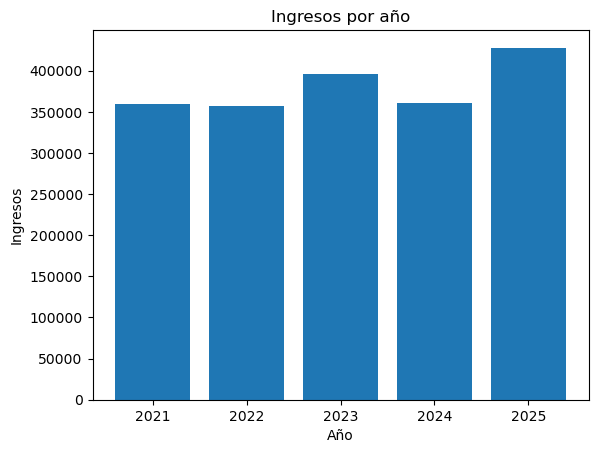

In [12]:
sql_anio = """
SELECT
  dt.anio,
  SUM(fm.importe) AS ingresos_anio
FROM FactMulta fm
JOIN DimTiempo dt ON dt.time_key = fm.time_key
GROUP BY dt.anio
ORDER BY dt.anio;
"""
df_anio = df_sql(sql_anio)
display(df_anio)

# Gráfico: barras por año
plt.figure()
plt.bar(df_anio['anio'].astype(str), df_anio['ingresos_anio'])
plt.title('Ingresos por año')
plt.xlabel('Año')
plt.ylabel('Ingresos')
plt.show()


## Drill-down: Ingresos diarios por oficial

,time_key,fecha,id_oficial,oficial,ingresos_dia
0,20240102,2024-01-02,44,Elijah Mendez,1000.0
1,20240105,2024-01-05,46,Oliver Santos,1380.0
2,20240105,2024-01-05,71,Oliver Mendez,2825.0
3,20240110,2024-01-10,120,Liam Aguilar,2990.0
4,20240111,2024-01-11,95,Fernanda Vargas,610.0
5,20240112,2024-01-12,8,Juan Reyes,2825.0
6,20240115,2024-01-15,7,Laura Romero,1850.0
7,20240115,2024-01-15,24,Jorge Hernandez,675.0
8,20240122,2024-01-22,90,Samuel Ruiz,625.0
9,20240131,2024-01-31,75,Elena Vargas,1740.0


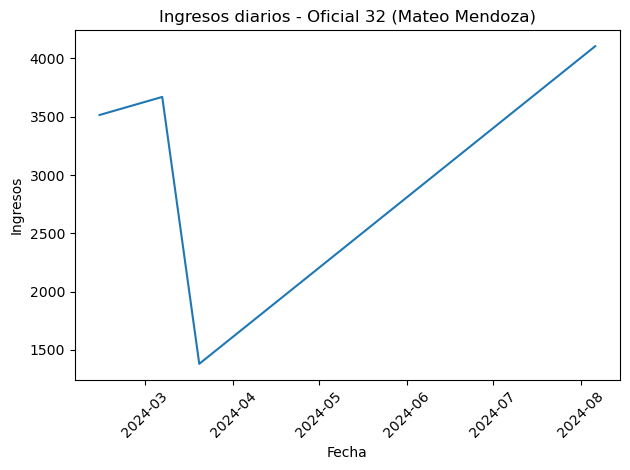

In [13]:
ANIO_FILTRO = 2024   # aquí se ajusta manualmente con estas opciones [2021, 2022, 2023, 2024, 2025]
MES_FILTRO  = None   # aquí se ajusta manualmente, cada mes esta ligado a un numero enero=1, febrero=2, marzo=3, etc. Hasta el 12 que es diciembre

cond_mes = "AND dt.mes = %(mes)s" if MES_FILTRO else ""
sql_dd = f"""
SELECT
  fm.time_key,
  dt.fecha,
  dof.id_oficial,
  dof.nombre AS oficial,
  SUM(fm.importe) AS ingresos_dia
FROM FactMulta fm
JOIN DimTiempo dt ON dt.time_key = fm.time_key
JOIN DimOficial dof ON dof.oficial_key = fm.oficial_key
WHERE dt.anio = %(anio)s {cond_mes}
GROUP BY fm.time_key, dt.fecha, dof.id_oficial, dof.nombre
ORDER BY dt.fecha, dof.id_oficial;
"""
params = {"anio": ANIO_FILTRO, "mes": MES_FILTRO}
df_dd = df_sql(sql_dd, params=params)
display(df_dd.head(20))

# Gráfico: para el top 1 oficial del periodo, línea de ingresos por día
if not df_dd.empty:
    top_oficial = (df_dd.groupby(['id_oficial','oficial'])['ingresos_dia']
                        .sum().sort_values(ascending=False).index[0])
    df_top = df_dd[(df_dd['id_oficial']==top_oficial[0]) & (df_dd['oficial']==top_oficial[1])].sort_values('fecha')
    plt.figure()
    plt.plot(df_top['fecha'], df_top['ingresos_dia'])
    plt.title(f'Ingresos diarios - Oficial {top_oficial[0]} ({top_oficial[1]})')
    plt.xlabel('Fecha')
    plt.ylabel('Ingresos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Slice: Multas emitidas en un mes específico

,anio,mes,multas_mes,ingresos_mes
0,2023,3,16,29105.0


,fecha,ingresos_dia,multas_dia
0,2023-03-01,1610.0,1
1,2023-03-02,675.0,1
2,2023-03-05,1165.0,1
3,2023-03-06,3215.0,2
4,2023-03-07,985.0,1


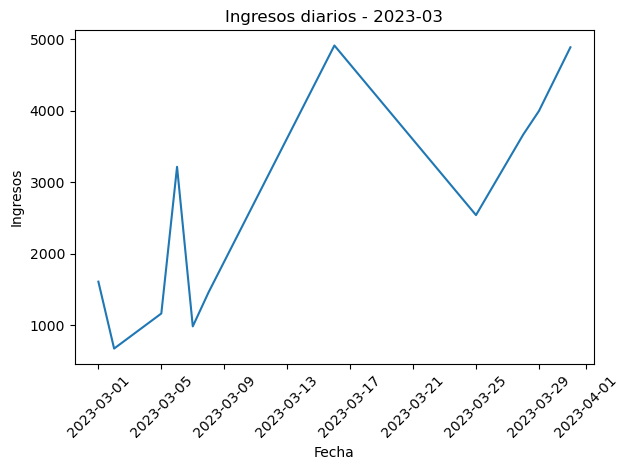

In [14]:
ANIO = 2023   # aquí se ajusta manualmente con estas opciones [2021, 2022, 2023, 2024, 2025]
MES  = 3   # aquí se ajusta manualmente, cada mes esta ligado a un numero enero=1, febrero=2, marzo=3, etc. Hasta el 12 que es diciembre

sql_slice_resumen = """
SELECT
  dt.anio, dt.mes,
  COUNT(*) AS multas_mes,
  SUM(fm.importe) AS ingresos_mes
FROM FactMulta fm
JOIN DimTiempo dt ON dt.time_key = fm.time_key
WHERE dt.anio = %(anio)s AND dt.mes = %(mes)s
GROUP BY dt.anio, dt.mes;
"""
df_res = df_sql(sql_slice_resumen, params={"anio": ANIO, "mes": MES})
display(df_res)

sql_slice_diario = """
SELECT
  dt.fecha,
  SUM(fm.importe) AS ingresos_dia,
  COUNT(*) AS multas_dia
FROM FactMulta fm
JOIN DimTiempo dt ON dt.time_key = fm.time_key
WHERE dt.anio = %(anio)s AND dt.mes = %(mes)s
GROUP BY dt.fecha
ORDER BY dt.fecha;
"""
df_d = df_sql(sql_slice_diario, params={"anio": ANIO, "mes": MES})
display(df_d.head())

# Gráfico: ingresos diarios del mes
if not df_d.empty:
    plt.figure()
    plt.plot(df_d['fecha'], df_d['ingresos_dia'])
    plt.title(f'Ingresos diarios - {ANIO}-{MES:02d}')
    plt.xlabel('Fecha')
    plt.ylabel('Ingresos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Dice: Ingresos por oficiales de cierto rango y conductores con casa propia

,rango,id_oficial,oficial,ingresos
0,Comandante,71,Oliver Mendez,5650.0
1,Comandante,42,Mateo Gomez,4885.0
2,Comandante,84,Diego Ruiz,4265.0
3,Comandante,95,Fernanda Vargas,4065.0
4,Comandante,6,Evelyn Torres,3740.0
5,Comandante,77,Isabella Sanchez,3670.0
6,Comandante,112,Fernanda Santos,3515.0
7,Comandante,70,Noah Mendoza,2950.0
8,Comandante,51,Juan Flores,2815.0
9,Comandante,49,Theodore Ortiz,2585.0


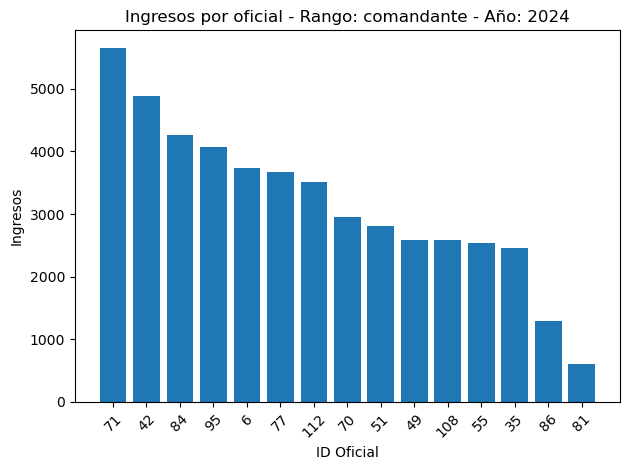

In [15]:
RANGO = 'comandante'   # aquí se ajusta manualmente con estas opciones ['comandante', 'inspector', 'oficial', 'sargento', 'subinspector']
ANIO_DICE = 2024     # aquí se ajusta manualmente con estas opciones [2021, 2022, 2023, 2024, 2025]

cond_anio = "AND dt.anio = %(anio)s" if ANIO_DICE else ""
sql_dice = f"""
SELECT
  dof.rango,
  dof.id_oficial,
  dof.nombre AS oficial,
  SUM(fm.importe) AS ingresos
FROM FactMulta fm
JOIN DimOficial dof    ON dof.oficial_key   = fm.oficial_key
LEFT JOIN DimConductor dco ON dco.conductor_key = fm.conductor_key
JOIN DimTiempo dt      ON dt.time_key = fm.time_key
WHERE dof.rango = %(rango)s
  AND (dco.casa_propia = 1 OR fm.conductor_key IS NULL)
  {cond_anio}
GROUP BY dof.rango, dof.id_oficial, dof.nombre
ORDER BY ingresos DESC;
"""
params = {"rango": RANGO, "anio": ANIO_DICE}
df_dice = df_sql(sql_dice, params=params)
display(df_dice.head(20))


if not df_dice.empty:
    top = df_dice.nlargest(15, 'ingresos')
    plt.figure()
    plt.bar(top['id_oficial'].astype(str), top['ingresos'])
    plt.title(f'Ingresos por oficial - Rango: {RANGO}' + (f' - Año: {ANIO_DICE}' if ANIO_DICE else ''))
    plt.xlabel('ID Oficial')
    plt.ylabel('Ingresos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Oficiales con mayor recaudación

,id_oficial,nombre,rango,total_recaudado,num_multas
0,115,Laura Aguilar,Subinspector,36825.0,16
1,30,Emily Ramirez,Inspector,32210.0,12
2,92,Isabella Mendez,Sargento,31175.0,12
3,29,Gabriela Ramos,Sargento,30925.0,9
4,21,Santiago Santos,Oficial,29295.0,12
5,86,Elena Cruz,Comandante,28015.0,10
6,51,Juan Flores,Comandante,27750.0,10
7,55,Diego Ramirez,Comandante,26570.0,11
8,65,Noah Diaz,Oficial,26535.0,11
9,102,Oliver Mendoza,Subinspector,26435.0,11


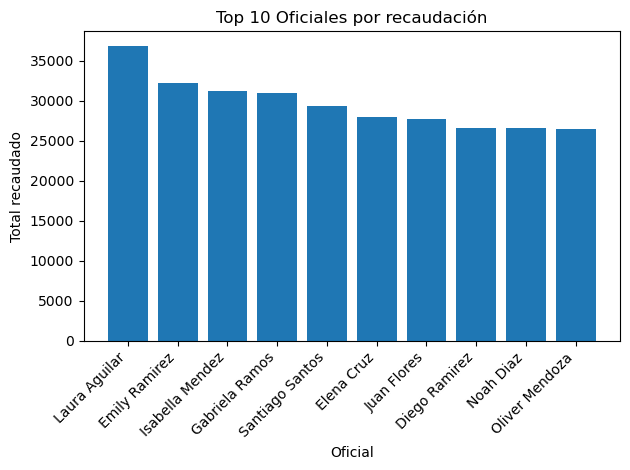

In [16]:
sql_top_oficiales = """
SELECT 
    dof.id_oficial,
    dof.nombre,
    dof.rango,
    SUM(fm.importe) AS total_recaudado,
    COUNT(*) AS num_multas
FROM FactMulta fm
JOIN DimOficial dof ON dof.oficial_key = fm.oficial_key
GROUP BY dof.id_oficial, dof.nombre, dof.rango
ORDER BY total_recaudado DESC
LIMIT 10;
"""
df_top_of = df_sql(sql_top_oficiales)
display(df_top_of)

# Gráfico: barras de recaudación
plt.figure()
plt.bar(df_top_of['nombre'], df_top_of['total_recaudado'])
plt.title('Top 10 Oficiales por recaudación')
plt.xlabel('Oficial')
plt.ylabel('Total recaudado')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Patrones temporales (multas por mes)

,anio,mes,total_multas,ingresos_mes
0,2021,1,11,20285.0
1,2021,2,16,48185.0
2,2021,3,11,30760.0
3,2021,4,12,24470.0
4,2021,5,16,33240.0
5,2021,6,17,30075.0
6,2021,7,14,22050.0
7,2021,8,11,30945.0
8,2021,9,10,23160.0
9,2021,10,13,23360.0


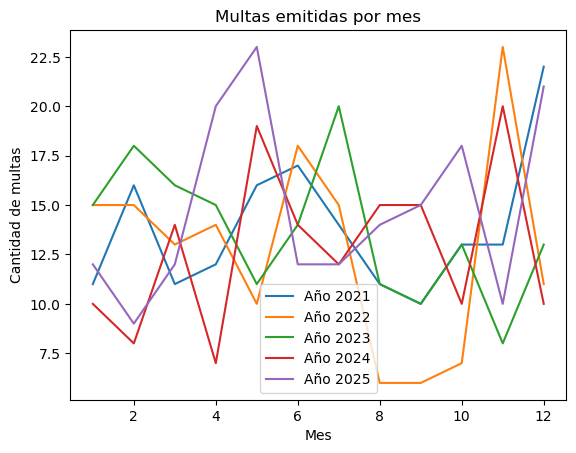

In [17]:
sql_multas_mes = """
SELECT 
    dt.anio,
    dt.mes,
    COUNT(*) AS total_multas,
    SUM(fm.importe) AS ingresos_mes
FROM FactMulta fm
JOIN DimTiempo dt ON dt.time_key = fm.time_key
GROUP BY dt.anio, dt.mes
ORDER BY dt.anio, dt.mes;
"""
df_mes = df_sql(sql_multas_mes)
display(df_mes.head(24))

# Gráfico: líneas por año
plt.figure()
for anio, sub in df_mes.groupby('anio'):
    plt.plot(sub['mes'], sub['total_multas'], label=f"Año {anio}")
plt.title('Multas emitidas por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de multas')
plt.legend()
plt.show()


## Patrones temporales (multas por día de la semana)

,dia_semana,total_multas,ingresos
0,3,132,316920.0
1,1,119,259275.0
2,6,120,299815.0
3,2,104,228680.0
4,4,126,311475.0
5,5,105,236940.0
6,7,109,247985.0


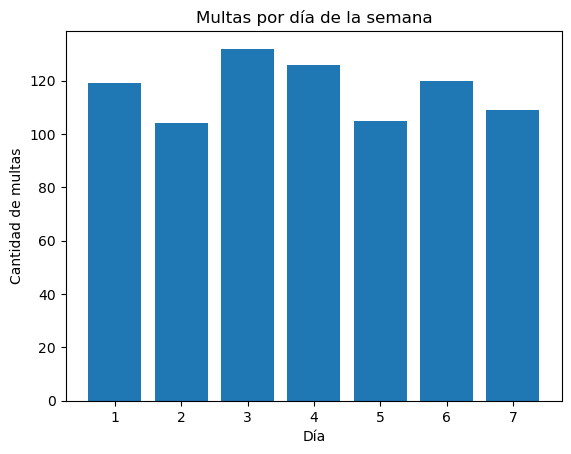

In [18]:
sql_multas_dia_semana = """
SELECT 
    dt.dia_semana,
    COUNT(*) AS total_multas,
    SUM(fm.importe) AS ingresos
FROM FactMulta fm
JOIN DimTiempo dt ON dt.time_key = fm.time_key
GROUP BY dt.dia_semana
ORDER BY FIELD(dt.dia_semana,'Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo');
"""
df_dias = df_sql(sql_multas_dia_semana)
display(df_dias)

# Gráfico: barras
plt.figure()
plt.bar(df_dias['dia_semana'], df_dias['total_multas'])
plt.title('Multas por día de la semana')
plt.xlabel('Día')
plt.ylabel('Cantidad de multas')
plt.show()


## Correlación: ingresos de conductores vs multas recibidas

,ingreso_mensual,num_multas,total_pagado
0,8052.24,3,5610.0
1,8082.19,1,2515.0
2,8299.49,4,7590.0
3,8340.15,3,8455.0
4,8515.99,2,1990.0
5,8978.62,6,16690.0
6,9022.82,5,8770.0
7,9042.69,4,7265.0
8,9548.08,4,12380.0
9,9574.51,6,15440.0


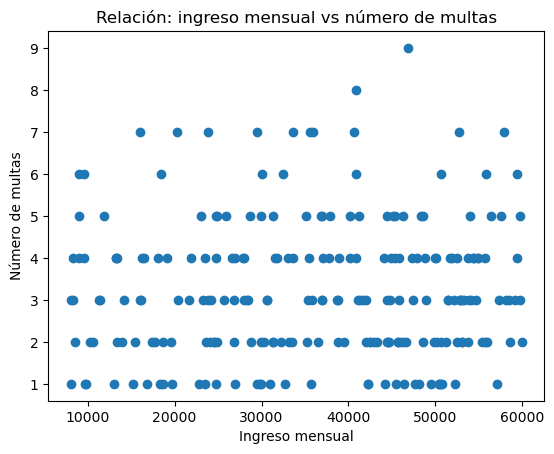

In [19]:
sql_corr = """
SELECT 
    dco.ingreso_mensual,
    COUNT(fm.fact_multa_id) AS num_multas,
    SUM(fm.importe) AS total_pagado
FROM FactMulta fm
JOIN DimConductor dco ON dco.conductor_key = fm.conductor_key
WHERE dco.ingreso_mensual IS NOT NULL
GROUP BY dco.ingreso_mensual
ORDER BY dco.ingreso_mensual;
"""
df_corr = df_sql(sql_corr)
display(df_corr.head(15))

# Gráfico: scatter plot
plt.figure()
plt.scatter(df_corr['ingreso_mensual'], df_corr['num_multas'])
plt.title('Relación: ingreso mensual vs número de multas')
plt.xlabel('Ingreso mensual')
plt.ylabel('Número de multas')
plt.show()
